In [41]:
# Input file name. The input file must contain two sheets with the following names: "infor" & "formula"
input_file = "mini project_v6"

# Output file name
output_file = f"{input_file}_results"

lst_features = [
    "Li",
    "aF",
    "aO",
    "sC",
    "sO",
    "sF",
    "pi",
    "cyclic",
    "apol",
    "Vabc-",
    "SLogP-r",
    "Radius-r",
]

lst_colors = [
    "tab:blue",
    "tab:green",
    "tab:orange",
    "tab:red",
    "tab:olive",
    "tab:purple",
    "tab:cyan",
    "tab:gray",
    "tab:brown",
    "magenta",
    "darkgreen",
    "deeppink",
]

# Histogram plot
bins_num = 30

# state randomness
random_state = 7

#other default setting...

C:\Users\Admin\AppData\Local\Temp\ipykernel_4836\2973860640.py:247: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.757' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.formula.loc[i, prop] = round(total_value, 3) if total_value != 0 else 0
C:\Users\Admin\AppData\Local\Temp\ipykernel_4836\2973860640.py:247: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '87.589' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.formula.loc[i, prop] = round(total_value, 3) if total_value != 0 else 0
C:\Users\Admin\AppData\Local\Temp\ipykernel_4836\2973860640.py:247: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '13.739' has dtype incompatible with int64, please explicitly c

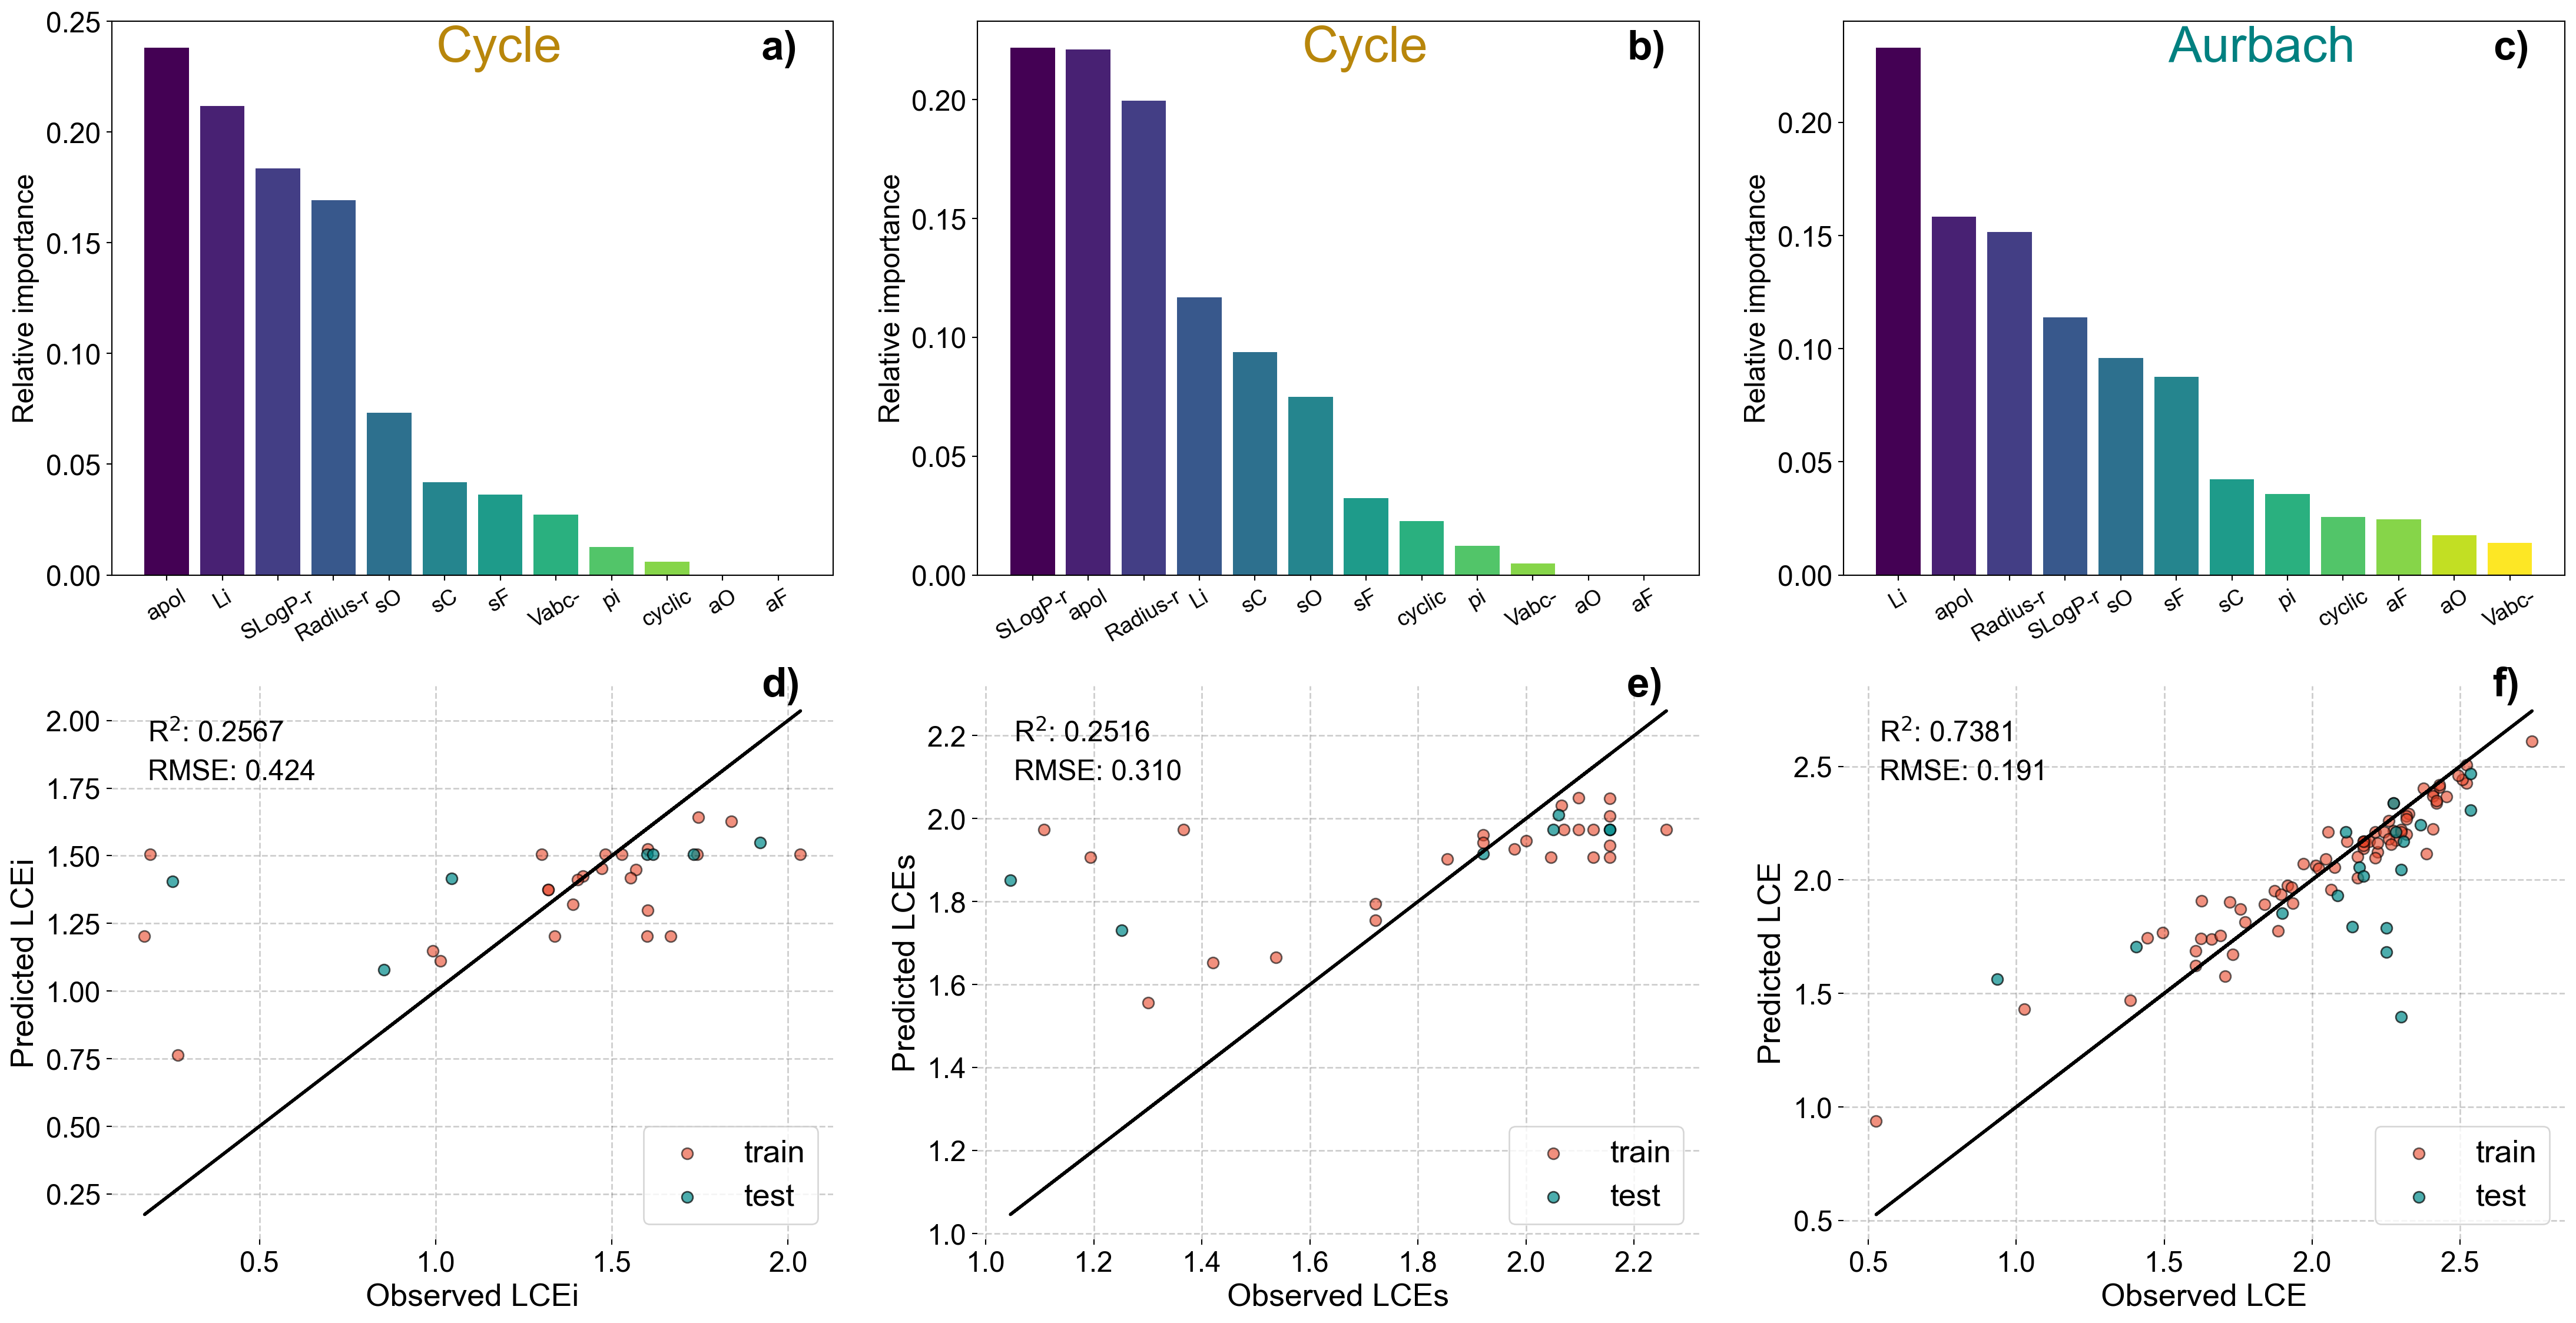

Accuracy: 78.1% 

GradientBoostingClassifier(loss='exponential', max_depth=25, min_samples_leaf=2,
                           n_estimators=462, random_state=7)
Accuracy: 67.4% 

RandomForestClassifier(max_depth=1, min_samples_leaf=38, n_estimators=28,
                       random_state=7)


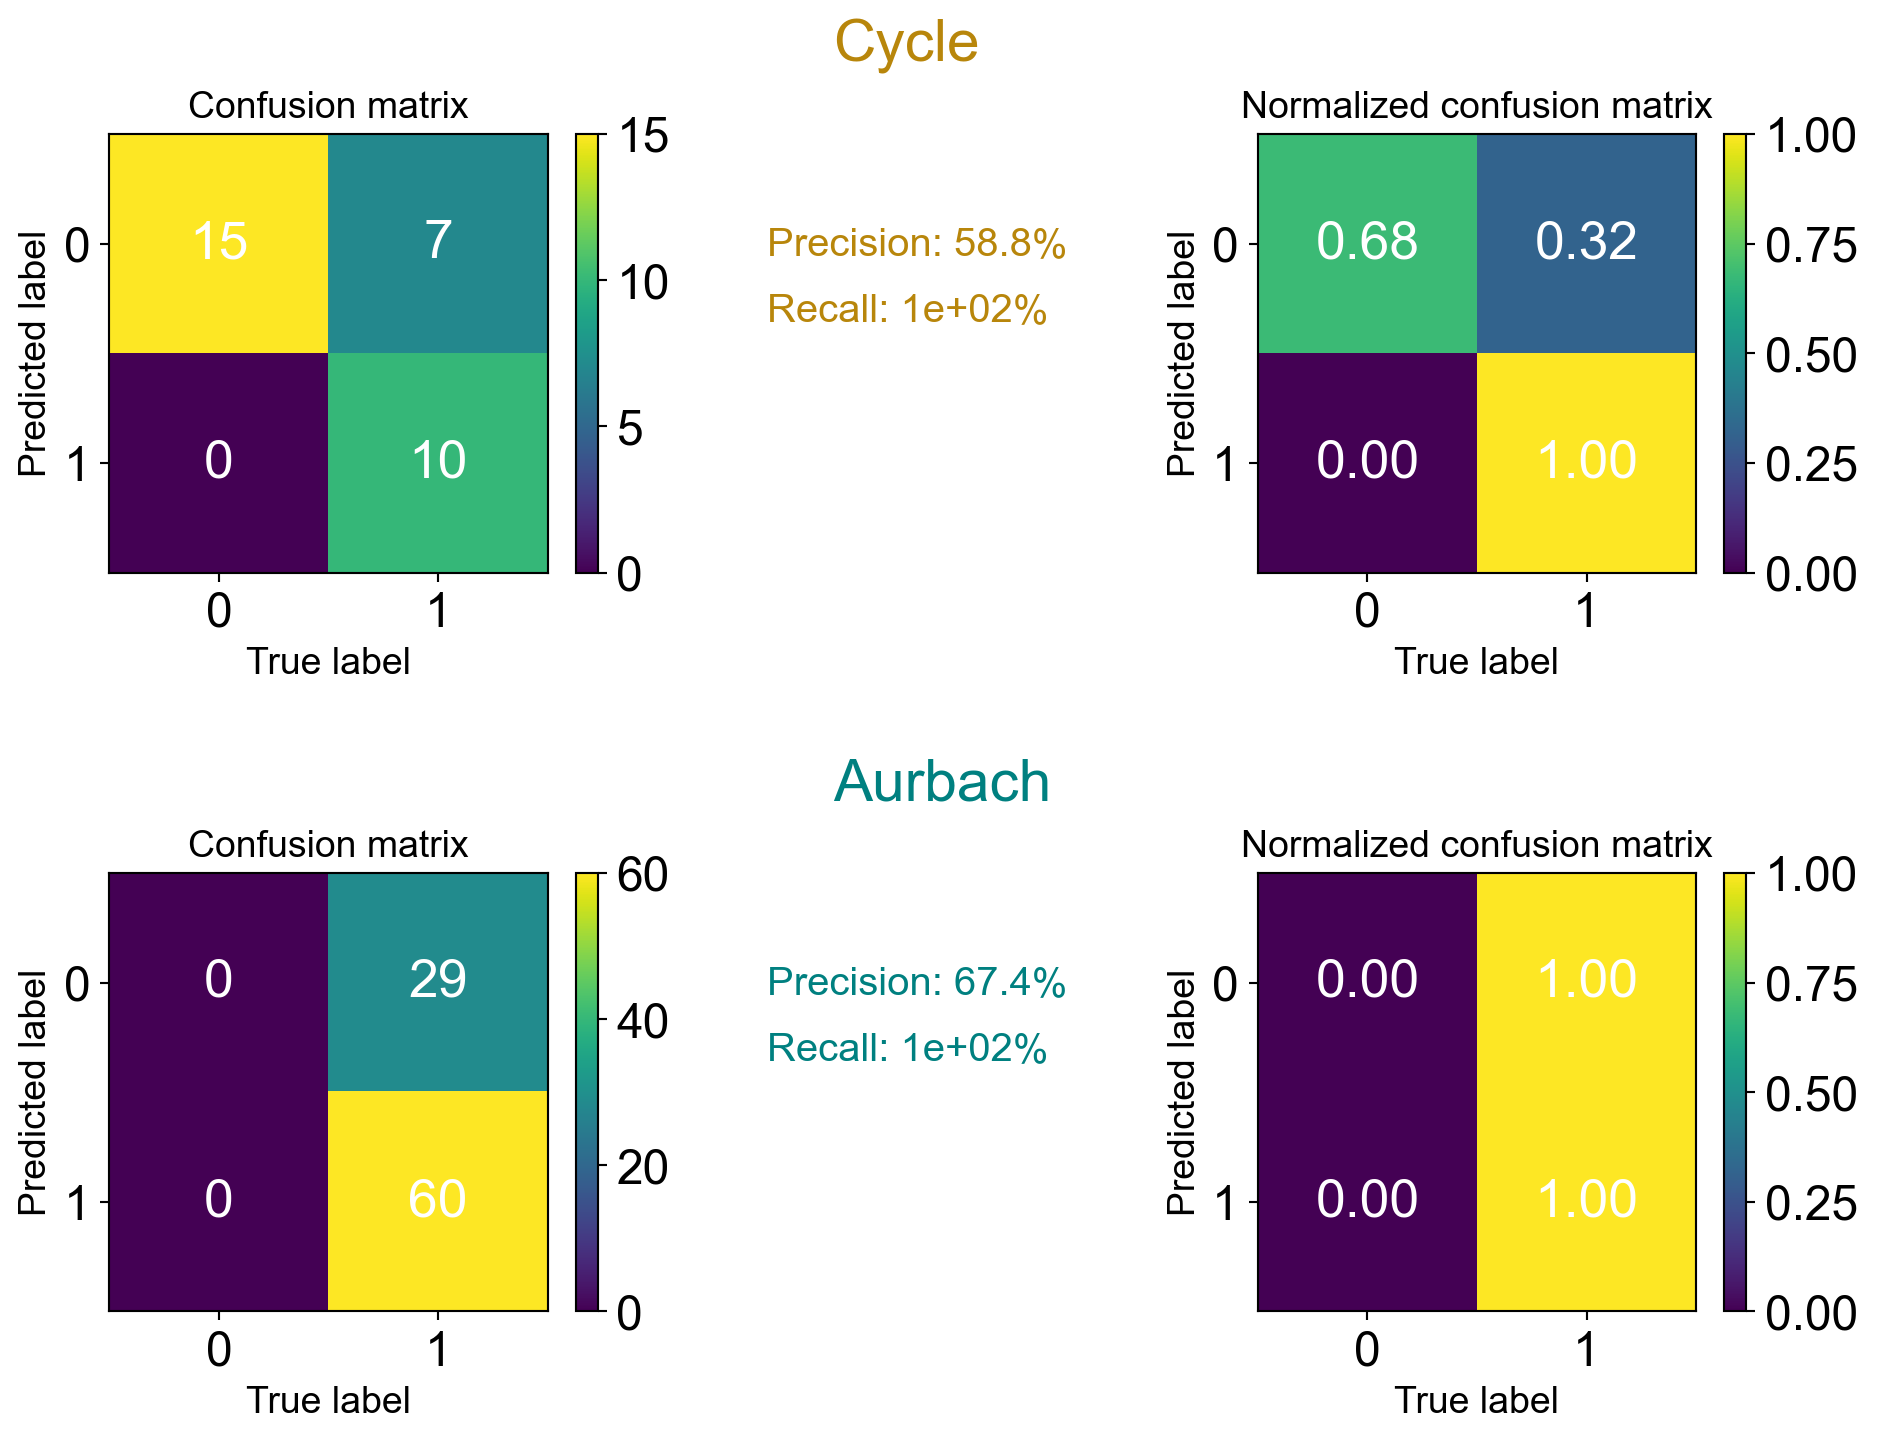

In [42]:
import pandas as pd
import numpy as np
import re
import itertools
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, confusion_matrix

# Font and size
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams.update({'font.size': 20})

class Main:
    def __init__(self, input_file=f'{input_file}.xlsx'):
        self.input_file = input_file
        self.formula = pd.read_excel(input_file, sheet_name='formula')
        self.infor = pd.read_excel(input_file, sheet_name='infor')
        # Declare these dicts as instance variables so they can be accessed throughout the class
        self.mw_dict = dict(zip(self.infor['compound'], self.infor['MW']))
        self.vabc_dict = dict(zip(self.infor['compound'], self.infor['Vabc'])) 
        self.o_dict = dict(zip(self.infor['compound'], self.infor['O']))
        self.f_dict = dict(zip(self.infor['compound'], self.infor['F']))
        self.c_dict = dict(zip(self.infor['compound'], self.infor['C']))
        self.h_dict = dict(zip(self.infor['compound'], self.infor['H']))
        self.SLogP_dict = dict(zip(self.infor['compound'], self.infor['SLogP']))
        self.cyclic_dict = dict(zip(self.infor['compound'], self.infor['cyclic']))
        self.smiles_dict = dict(zip(self.infor['compound'], self.infor['SMILES']))
    # draw cmap plot
    def plot_cmap(labels, data, ax, chart_type='bar', cmap='viridis'):
        scaled_data = np.linspace(0.05, 1, len(data))
        colors = [mpl.colormaps.get_cmap(cmap)(decimal) for decimal in scaled_data]
        fig.patch.set_facecolor('white')

        try:
            getattr(ax, chart_type)(labels, data, color=colors)
        except AttributeError:
            getattr(ax, chart_type)(data, labels=labels, colors=colors)

    # draw confusion plot
    def plot_confusion(self, Y, ax, matrix, title='Confusion Matrix', rf='.0f', shrink=0.3):
        im = ax.imshow(matrix, interpolation='nearest', cmap='viridis')
        ax.set_xticks(range(np.unique(Y).shape[0]))
        ax.set_yticks(range(np.unique(Y).shape[0]))
        ax.set_title(title, fontsize=14)
        ax.set_xlabel('True label', fontsize=14)
        ax.set_ylabel('Predicted label', fontsize=14)
        cbar = plt.colorbar(im, ax=ax, shrink=shrink)
        for m, n in itertools.product(range(matrix.shape[1]), range(matrix.shape[0])):
            ax.text(n, m, format(matrix[m, n], rf), ha="center", va="center", color="w")


    # create small random number
    def rand_jitter(arr):
        np.random.seed(random_state)
        if len(arr) == 0:
            stdev = 0
        else:
            stdev = 0.04 * (max(arr) - min(arr))
        jitter = arr + (np.random.randn(len(arr)) * stdev)
        return jitter
        
    # calculate spearman correlation coefficient
    def cal_rsq(x,y):
        rsq = spearmanr(x, y)[0]
        return rsq

    def moles(self):
        mw_dict = self.mw_dict
        o_dict = self.o_dict
        f_dict = self.f_dict
        c_dict = self.c_dict
        h_dict = self.h_dict
        self.formula.columns = self.formula.columns.str.strip()
        # Process formula data
        for index, row in self.formula.iterrows():
            formula_str = str(row['formula']).strip()
            match = re.match(r"([A-Za-z0-9\-]+(?:-[A-Za-z0-9\-]+)*)\s*\(([\d\.\-]+(?:-[\d\.\-]+)*)\s*mol\)", formula_str)
            if not match:
                continue
                
            compounds_part, mols_part = match.groups()
            compounds = compounds_part.split("-")
            compounds = [compound + " " for compound in compounds]
            original_mols = [float(m) for m in mols_part.split("-")]
                
            if len(compounds) != len(original_mols):
                continue
                    
            total_mass = 0
            for compound, mol in zip(compounds, original_mols):
                for k in mw_dict.keys():
                    if compound in k:
                        total_mass += mw_dict[k] * mol if pd.notna(mw_dict[k]) else 0
                        break
                
            scale_factor = 100 / total_mass if total_mass > 0 else 0
                
            for i, (compound, mol_val) in enumerate(zip(compounds, original_mols), start=1):
                self.formula.loc[index, f"c{i}"] = compound
                self.formula.loc[index, f"n{i}"] = mol_val * scale_factor
        # tính số mol của Li và sol
        for i in self.formula.index:
            s_count = 1  
            a_count = 1
            Li = 0
            sol = 0
            
            for j in range(1, 9):
                c_col = f'c{j}'
                n_col = f'n{j}'
                if c_col in self.formula.columns and pd.notna(self.formula.loc[i, c_col]):
                    compound = self.formula.loc[i, c_col]
                    n_value = self.formula.loc[i, n_col]
                    
                    if 'Li' in compound:
                        Li += n_value
                        for k in o_dict.keys():
                            if compound in k:
                                self.formula.loc[i, f'a{a_count}O'] = o_dict[k] if pd.notna(o_dict[k]) else 0
                                self.formula.loc[i, f'a{a_count}F'] = f_dict[k] if pd.notna(f_dict[k]) else 0
                                a_count += 1
                                break
                    else:
                        sol += n_value
                        for k in o_dict.keys():
                            if compound in k:
                                self.formula.loc[i, f's{s_count}C'] = c_dict[k] if pd.notna(c_dict[k]) else 0
                                self.formula.loc[i, f's{s_count}H'] = h_dict[k] if pd.notna(h_dict[k]) else 0
                                self.formula.loc[i, f's{s_count}O'] = o_dict[k] if pd.notna(o_dict[k]) else 0
                                self.formula.loc[i, f's{s_count}F'] = f_dict[k] if pd.notna(f_dict[k]) else 0
                                s_count += 1
                                break
            
            self.formula.loc[i, 'Li'] = Li
            self.formula.loc[i, 'sol'] = sol
            self.formula.loc[i, 'Li/sol'] = round(Li/sol, 3) if sol != 0 else 0
        # tính tỉ lệ số mol của các nguyên tố
        prefix_suffix_pairs = [
            ('a', 'O'),
            ('a', 'F'),
            ('s', 'C'),
            ('s', 'H'),
            ('s', 'O'),
            ('s', 'F'),
            ('s', 'P'),
            ('s', 'S')
        ]

        for prefix, suffix in prefix_suffix_pairs:
            cols = [col for col in self.formula.columns if col.startswith(prefix) and col.endswith(suffix) and len(col) == 3]
            self.formula[prefix + suffix] = self.formula[cols].sum(axis=1, skipna=True)

        self.formula['sF/sC'] = self.formula.apply(lambda x: round(x['sF'] / x['sC'], 2) if pd.notna(x['sF']) and pd.notna(x['sC']) and x['sC'] != 0 else 0, axis=1)
        self.formula['sF/sO'] = self.formula.apply(lambda x: round(x['sF'] / x['sO'], 2) if pd.notna(x['sF']) and pd.notna(x['sO']) and x['sO'] != 0 else 0, axis=1)
        self.formula['sC.sH'] = self.formula.apply(lambda x: round(x['sC'] * x['sH'], 2) if pd.notna(x['sC']) and pd.notna(x['sH']) and x['sH'] != 0 else 0, axis=1)
        self.formula['sO/sC'] = self.formula.apply(lambda x: round(x['sO'] / x['sC'], 2) if pd.notna(x['sO']) and pd.notna(x['sC']) and x['sC'] != 0 else 0, axis=1)
    
        # tính số nối đôi O trong các hợp chất
    def smiles(self):
        smiles_dict = self.smiles_dict
        self.formula['dbO'] = 0
        for i in self.formula.index:
            db_count = 0
            for j in range(1, 9):
                c_col = f'c{j}'
                if c_col in self.formula.columns and pd.notna(self.formula.loc[i, c_col]):
                    compound = self.formula.loc[i, c_col]
                    for k in smiles_dict.keys():
                        if compound in k and pd.notna(smiles_dict[k]):
                            db_count += smiles_dict[k].count('=O')
                            break
            self.formula.loc[i, 'dbO'] = db_count
        self.formula['sbO'] = self.formula['sO'] - self.formula['dbO']
        # tính pct
    def pct(self):
        for i in range(1, 9):
            c_col = f'c{i}'
            n_col = f'n{i}'
            
            if c_col in self.formula.columns:
                pct_col = f'%n{i}'
                self.formula[pct_col] = self.formula.apply(
                    lambda row: round(row[n_col] / row['sol'] * 100, 2) if pd.notna(row[c_col]) and 'Li' not in str(row[c_col]) else np.nan,
                    axis=1
                )
        # tính density
    def density(self):
        mw_dict = self.mw_dict
        vabc_dict = self.vabc_dict
        for i in self.formula.index:
            total_mw = 0
            total_vabc = 0
            for j in range(1, 9):
                c_col = f'c{j}'
                n_col = f'n{j}'
                if c_col in self.formula.columns and pd.notna(self.formula.loc[i, c_col]):
                    compound = self.formula.loc[i, c_col]
                    n_value = self.formula.loc[i, n_col]
                    if 'Li' not in compound:
                        for k in mw_dict.keys():
                            if compound in k:
                                total_mw += mw_dict[k] * n_value if pd.notna(mw_dict[k]) else 0
                                total_vabc += vabc_dict[k] * n_value if pd.notna(vabc_dict[k]) else 0
                                break
            
            self.formula.loc[i, 'density'] = round(total_mw/total_vabc, 3) if total_vabc != 0 else 0
        # tính radius, apol, bpol, Vabc
    def properties(self):
        properties = ['Radius', 'Vabc', 'apol', 'bpol']
        property_dicts = {prop: dict(zip(self.infor['compound'], self.infor[prop])) for prop in properties}
        SLogP_dict = self.SLogP_dict
        for prop in properties:
            self.formula[f'{prop}'] = self.formula[prop].astype(float)  
            self.formula[f'{prop}-'] = self.formula[f'{prop}-'].astype(float)
            self.formula[f'{prop}-r'] = self.formula[f'{prop}-r'].astype(float)
            self.formula[f'{prop}+'] = self.formula[f'{prop}+'].astype(float)
            self.formula[prop] = 0
            self.formula[f'{prop}-'] = 1
        for i in self.formula.index:
            for prop in properties:
                total_value = 0
                minus_value = 1
                for j in range(1, 9):
                    c_col = f'c{j}'
                    n_col = f'n{j}'
                    pct_col = f'%n{j}'
                    if c_col in self.formula.columns and pd.notna(self.formula.loc[i, c_col]):
                        compound = self.formula.loc[i, c_col]
                        n_value = self.formula.loc[i, n_col]
                        n2_value = self.formula.loc[i, pct_col]
                        if 'Li' not in compound:
                            for k in property_dicts[prop].keys():
                                if compound in k:
                                    total_value += property_dicts[prop][k] * n_value if pd.notna(property_dicts[prop][k]) else 0
                                    minus_value *= property_dicts[prop][k] ** n2_value if pd.notna(property_dicts[prop][k]) else 1
                                    break
                self.formula.loc[i, prop] = round(total_value, 3) if total_value != 0 else 0
                self.formula[f'{prop}-'] = self.formula[f'{prop}-'].astype(float)
                self.formula.loc[i, f'{prop}-'] = round(minus_value, 3) if minus_value != 1 else 1
        for prop in properties:
            self.formula[f'{prop}-r'] = self.formula.apply(lambda x: round(x[prop] / x['sol'], 3) if x['sol'] != 0 else 0, axis=1)
            self.formula[f'{prop}+'] = self.formula.apply(lambda x: round((2 * x[f'{prop}-r']) - x[f'{prop}-'], 3), axis=1)
        # tính SLogP
        for i in self.formula.index:
            total_slogp = 0
            for j in range(1, 9):
                c_col = f'c{j}'
                pct_col = f'%n{j}'
                if c_col in self.formula.columns and pd.notna(self.formula.loc[i, c_col]):
                    compound = self.formula.loc[i, c_col]
                    n2_value = self.formula.loc[i, pct_col]
                    if 'Li' not in compound:
                        for k in SLogP_dict.keys():
                            if compound in k:
                                if pd.notna(SLogP_dict[k]) and pd.notna(n2_value):
                                    total_slogp += 10**SLogP_dict[k] * n2_value
                                break
                                
            self.formula.loc[i, 'SLogP-r'] = round(np.log10(total_slogp), 3) if total_slogp > 0 else 0
        # tính cyclic
    def cyclic(self):
        cyclic_dict = self.cyclic_dict
        for i in self.formula.index:
            total_cyclic = 0
            for j in range(1, 9):
                c_col = f'c{j}'
                n_col = f'n{j}'
                if c_col in self.formula.columns and pd.notna(self.formula.loc[i, c_col]):
                    compound = self.formula.loc[i, c_col]
                    n_value = self.formula.loc[i, n_col]
                    if 'Li' not in compound:
                        for k in cyclic_dict.keys():
                            if compound in k:
                                total_cyclic += cyclic_dict[k] if pd.notna(cyclic_dict[k]) else 0
                                break
            self.formula.loc[i, 'cyclic'] = round(total_cyclic, 3) if total_cyclic != 0 else 0
    # tính pi
    def pi(self):
        smiles_dict = self.smiles_dict
        self.formula['pi'] = 0
        for i in self.formula.index:
            pi_count = 0
            for j in range(1, 9):
                c_col = f'c{j}'
                if c_col in self.formula.columns and pd.notna(self.formula.loc[i, c_col]):
                    compound = self.formula.loc[i, c_col]
                    if 'Li' not in compound:  # Only count for non-Li compounds
                        for k in smiles_dict.keys():
                            if compound in k and pd.notna(smiles_dict[k]):
                                pi_count += smiles_dict[k].count('=')  # Count all double bonds
                                break
            self.formula.loc[i, 'pi'] = pi_count
        
        # save out file with calculated results
        with pd.ExcelWriter(f'{output_file}.xlsx') as writer:
            self.formula.to_excel(writer, sheet_name='formula', index=True)
            self.infor.to_excel(writer, sheet_name='infor', index=True)
    def plot_Aurbach(self):
        color = lst_colors
        grid_color = lst_colors
        df = pd.read_excel(f'{output_file}.xlsx', sheet_name='formula')
        method_grp = df.groupby('method')
        cycle = method_grp.get_group('Cycle')
        aurbach = method_grp.get_group('Aurbach')
        fig, axs = plt.subplots(3, 4, figsize=(28, 18), dpi = 192)
        ########################## plot LCE ############################### 
        x_names = ['Li', 'aF', 'aO', 'sC', 'sO', 'sF', 'pi', 'cyclic', 'apol', 'Vabc-', 'SLogP-r', 'Radius-r']
        y20 = aurbach['LCEi'].to_numpy()

        count = 0
        for j in range(3):
            for i in range(4):
                c1 = aurbach[x_names[count]].astype(float)
                scatter = axs[j, i].scatter(rand_jitter(y20), y20, c=c1, cmap='RdYlGn', s=40, alpha=0.7)

                # Set plot limits and grid
                axs[j, i].set_ylim(-0.1, 2.8)
                axs[j, i].grid(color=grid_color[count], linestyle='--', linewidth=2, alpha=0.2)

                # Hide spines
                for spine in ["top", "right", "bottom", "left"]:
                    axs[j, i].spines[spine].set_visible(False)

                # Add color bar
                cbar = plt.colorbar(scatter, ax=axs[j, i])
                cbar.set_label(x_names[count], fontsize=26, color=grid_color[count])

                # Add axis labels
                if i == 0:
                    axs[j, i].set_ylabel('LCE', fontweight="bold", fontsize=22)
                if j == 2:
                    axs[j, i].set_xlabel('LCE + Jitter', fontweight="bold", fontsize=22)

                count += 1

        # Add title text
        axs[0, 1].text(0.94, 1.08, 'Aurbach', fontsize=36, c='teal', verticalalignment='center', transform=axs[0, 1].transAxes)

        # Save the figure
        #plt.savefig('aurbach_LCE + jitter.tif', bbox_inches='tight')
    def plot_Cycle(self):
        grid_color = lst_colors
        color = lst_colors
        df = pd.read_excel(f'{output_file}.xlsx', sheet_name='formula')
        method_grp = df.groupby('method')
        cycle = method_grp.get_group('Cycle')
        aurbach = method_grp.get_group('Aurbach')
        fig, axs = plt.subplots(3, 4, figsize=(28, 18), dpi = 192)
        ########################## plot LCEi ############################### 
        x_names = ['Li', 'aF', 'aO', 'sC', 'sO', 'sF', 'pi', 'cyclic', 'apol', 'Vabc-', 'SLogP-r', 'Radius-r']
        x1 = cycle['LCEi']
        y1 = cycle['LCEs']

        count = 0
        for j in range(3):
            for i in range(4):
                c1 = cycle[x_names[count]].astype(float)
                scatter = axs[j, i].scatter(x1, y1, c=c1, cmap='RdYlGn', s=40, alpha=0.7)

                # Set plot limits and grid
                axs[j, i].set_ylim(-0.1, 2.8)
                axs[j, i].grid(color=grid_color[count], linestyle='--', linewidth=2, alpha=0.2)

                # Hide spines
                for spine in ["top", "right", "bottom", "left"]:
                    axs[j, i].spines[spine].set_visible(False)

                # Add color bar
                cbar = plt.colorbar(scatter, ax=axs[j, i])
                cbar.set_label(x_names[count], fontsize=26, color=grid_color[count])

                # Add axis labels
                if i == 0:
                    axs[j, i].set_ylabel('LCEs', fontweight="bold", fontsize=22)
                if j == 2:
                    axs[j, i].set_xlabel('LCEi', fontweight="bold", fontsize=22)

                count += 1

        # Add title text
        axs[0, 1].text(1.08, 1.1, 'Cycle', fontsize=36, color='darkgoldenrod', verticalalignment='center', transform=axs[0, 1].transAxes)

        # Save the figure
        #plt.savefig('cycle_LCEs+LCEi.tif', bbox_inches='tight')
        plt.show()
    def plot_Cycle2(self):
        cal_rsq = self.cal_rsq  
        grid_color = lst_colors
        color = lst_colors
        df = pd.read_excel(f'{output_file}.xlsx', sheet_name='formula')
        method_grp = df.groupby('method')
        cycle = method_grp.get_group('Cycle')
        aurbach = method_grp.get_group('Aurbach')
        fig, axs = plt.subplots(3, 4, figsize=(28, 18), dpi = 192)
        ########################## plot LCEi ############################### 
        x_names = ['Li', 'aF', 'aO', 'sC', 'sO', 'sF', 'pi', 'cyclic', 'apol', 'Vabc-', 'SLogP-r', 'Radius-r']
        y_name = 'LCEi'

        count = 0
        for j in range(3):
            for i in range(4):
                if x_names[count] == 'conductivity (mS.cm-1)':
                    df_drop = cycle.dropna(subset=[x_names[count]], how='any')
                    x = df_drop[x_names[count]].astype(float)
                    y = df_drop[y_name].astype(float)
                else:
                    x = cycle[x_names[count]].astype(float)
                    y = cycle[y_name].astype(float)

                axs[j, i].scatter(x, y, edgecolor='black', linewidth=1, s=50, alpha=0.5, c=color[count])
                axs[j, i].set_xlabel(x_names[count], fontweight="bold", fontsize=22, color=grid_color[count])
                axs[j, i].set_ylabel(y_name, fontweight="bold", fontsize=22)
                axs[j, i].set_ylim(-0.1, 2.6)

                axs[j, i].grid(color=grid_color[count], linestyle='--', linewidth=2, alpha=0.2)

                for spine in ["top", "right", "bottom", "left"]:
                    axs[j, i].spines[spine].set_visible(False)

                axs[j, i].text(0.85, 0.1, '{:0.2f}'.format(cal_rsq(x, y)),
                            fontsize=20,
                            color='black',
                            verticalalignment='center',
                            transform=axs[j, i].transAxes,
                            bbox=dict(facecolor='white', edgecolor=grid_color[count], boxstyle='round'))

                count += 1

        # Add title text
        axs[0, 1].text(0.98, 1.1, 'Cycle', fontsize=36, color='darkgoldenrod', verticalalignment='center', transform=axs[0, 1].transAxes)

        # Save the figure
        #plt.savefig('cycle_LCEi.tif', bbox_inches='tight')
    def plot_Cycle3(self):
        cal_rsq = self.cal_rsq
        grid_color = lst_colors
        color = lst_colors
        df = pd.read_excel(f'{output_file}.xlsx', sheet_name='formula')
        method_grp = df.groupby('method')
        cycle = method_grp.get_group('Cycle')
        aurbach = method_grp.get_group('Aurbach')
        fig, axs = plt.subplots(3, 4, figsize=(28, 18), dpi = 192)

        ########################## plot LCEs ############################### 

        x_names = ['Li', 'aF', 'aO', 'sC', 'sO', 'sF', 'pi', 'cyclic', 'apol', 'Vabc-', 'SLogP-r', 'Radius-r']
        y_name = 'LCEs'

        count = 0
        for j in range(3):
            for i in range(4):
                if x_names[count] == 'conductivity (mS.cm-1)':
                    df_drop = cycle.dropna(subset=x_names[count], how='any')
                    x = df_drop[x_names[count]].astype(float)
                    y = df_drop[y_name].astype(float)
                else:
                    x = cycle[x_names[count]].astype(float)
                    y = cycle[y_name].astype(float)
                    
                axs[j, i].scatter(x, y, edgecolor='black', linewidth=1, s=50, alpha=0.5, c=color[count])
                axs[j, i].set_xlabel(x_names[count], fontweight="bold", fontsize=22, c=grid_color[count])
                axs[j, i].set_ylabel(y_name, fontweight="bold", fontsize=22)
                axs[j, i].set_ylim(-0.1, 2.6)
                
                axs[j, i].grid(color=grid_color[count], linestyle ='--', linewidth=2, alpha=0.2)
            
                for spine in ["top", "right", "bottom", "left"]:
                    axs[j, i].spines[spine].set_visible(False)
                
                axs[j, i].text(0.85, 0.1, '{:0.2f}'.format(cal_rsq(x,y)),
                            fontsize=20,
                            c='black',
                            verticalalignment='center',
                            transform=axs[j, i].transAxes,
                            bbox=dict(facecolor='white', edgecolor=grid_color[count], boxstyle='round'))
                
                count+=1
                
        axs[0,1].text(0.98, 1.1, 'Cycle', fontsize=36, c='darkgoldenrod', verticalalignment='center', transform=axs[0,1].transAxes)

        #plt.savefig('cycle_LCEs.tif', bbox_inches = 'tight')
    def plot_Aurbach2(self):
        cal_rsq = self.cal_rsq
        grid_color = lst_colors
        color = lst_colors
        df = pd.read_excel(f'{output_file}.xlsx', sheet_name='formula')
        method_grp = df.groupby('method')
        cycle = method_grp.get_group('Cycle')
        aurbach = method_grp.get_group('Aurbach')
        fig, axs = plt.subplots(3, 4, figsize=(28, 18), dpi = 192)

        ########################## plot LCEi ############################### 

        x_names = ['Li', 'aF', 'aO', 'sC', 'sO', 'sF', 'pi', 'cyclic', 'apol', 'Vabc-', 'SLogP-r', 'Radius-r']
        y_name = 'LCEi'

        count = 0
        for j in range(3):
            for i in range(4):
                if x_names[count] == 'conductivity (mS.cm-1)':
                    df_drop = aurbach.dropna(subset=x_names[count], how='any')
                    x = df_drop[x_names[count]].astype(float)
                    y = df_drop[y_name].astype(float)
                else:
                    x = aurbach[x_names[count]].astype(float)
                    y = aurbach[y_name].astype(float)
                    
                axs[j, i].scatter(x, y, edgecolor='black', linewidth=1, s=60, alpha=0.5, c=color[count])
                axs[j, i].set_xlabel(x_names[count], fontweight="bold", fontsize=22, c=grid_color[count])
                axs[j, i].set_ylabel('LCE', fontweight="bold", fontsize=22)
                axs[j, i].set_ylim(-0.1, 2.6)
                
                axs[j, i].grid(color=grid_color[count], linestyle ='--', linewidth=2, alpha=0.2)
            
                for spine in ["top", "right", "bottom", "left"]:
                    axs[j, i].spines[spine].set_visible(False)

                axs[j, i].text(0.85, 0.1, '{:0.2f}'.format(cal_rsq(x,y)),
                            fontsize=20,
                            c='black',
                            verticalalignment='center',
                            transform=axs[j, i].transAxes,
                            bbox=dict(facecolor='white', edgecolor=grid_color[count], boxstyle='round'))
                
                count+=1
                
        axs[0,1].text(0.94, 1.08, 'Aurbach', fontsize=36, c='teal', verticalalignment='center', transform=axs[0,1].transAxes)

        #plt.savefig('aurbach_LCE.tif', bbox_inches = 'tight')
    def regression(self):
        df = pd.read_excel(f'{output_file}.xlsx', sheet_name='formula')
        method_grp = df.groupby('method')
        cycle = method_grp.get_group('Cycle')
        aurbach = method_grp.get_group('Aurbach')
        y = ['LCEi', 'LCEs', 'LCEs']
        names = [cycle, cycle, aurbach]
        tags = ['a)', 'd)', 'b)', 'e)', 'c)', 'f)']
        split = 0.8
        #################################### Settings #################################### 
        fig, axs = plt.subplots(2,3, figsize=(28, 14), dpi = 192)
        scaler = MinMaxScaler()
        count=0

        model_cycle = RandomForestRegressor(n_estimators=140,
                                            max_depth=30,
                                            criterion='absolute_error',
                                            random_state=random_state)

        model_aurbach = RandomForestRegressor(n_estimators=340,
                                            max_depth=24,
                                            criterion='absolute_error',
                                            random_state=random_state)

        models = [model_cycle, model_cycle, model_aurbach]

        #################################### Running #################################### 
        for j in range(3):
            file = names[j]
            standardized_data = scaler.fit_transform(file[lst_features])
            df_std = pd.DataFrame(standardized_data, columns=file[lst_features].columns)
            X = df_std[lst_features]
            Y = file[y[j]]

            x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size = split, random_state=random_state)

            # Train model
            model = models[j].fit(x_train, y_train)
            y_train_predict = model.predict(x_train)
            y_test_predict = model.predict(x_test)
            y_predict = model.predict(X)
            
            importances = model.feature_importances_
            sorted_indices = np.argsort(importances)[::-1]

            # Evaluate model:
            rmse = root_mean_squared_error(Y, y_predict)
            rsq = r2_score(Y, y_predict)
                
            # Create bar plot with viridis colormap
            colors = plt.cm.viridis(np.linspace(0, 1, len(importances[sorted_indices])))
            axs[0,j].bar(range(x_train.shape[1]), importances[sorted_indices], color=colors)

            axs[0,j].set_ylabel("Relative importance", fontsize=18)
            #axs[0,j].set_ylabel("Mean decrease in impurity", fontsize=18)
            axs[0,j].set_xticks(range(x_train.shape[1]), x_train.columns[sorted_indices], rotation=0, fontsize=14)
            axs[0,j].set_xticks(range(x_train.shape[1]), [lst_features[i] for i in sorted_indices], rotation = 30)
            axs[0,j].text(0.9, 0.95, tags[count], fontsize=26, c='black', verticalalignment='center', weight='bold', transform=axs[0,j].transAxes)

            axs[1,j].scatter(y_train, y_train_predict, edgecolor='black', linewidth=1, s = 50, alpha = 0.6, c="#e84629", label='train')
            axs[1,j].scatter(y_test, y_test_predict, edgecolor='black', linewidth=1, s = 50, alpha = 0.7, c="darkcyan", label='test')
            axs[1,j].plot(Y, Y, c = 'black', linewidth = 2)
            
            axs[1,j].set_xlabel(f"Observed {y[j]}")
            axs[1,j].set_ylabel(f"Predicted {y[j]}")
            axs[1,j].legend(loc='lower right', )
            axs[1,j].grid(color='black', linestyle='--', linewidth=1, alpha=0.2)
            axs[1,j].spines["top"].set_visible(False)
            axs[1,j].spines["right"].set_visible(False)
            axs[1,j].spines["bottom"].set_visible(False)
            axs[1,j].spines["left"].set_visible(False)
            
            axs[1,j].text(0.9, 1, tags[count+1], fontsize=26, c='black', verticalalignment='center', weight='bold', transform=axs[1,j].transAxes)
            axs[1,j].text(0.05, 0.9, f'R$^2$: {round(rsq, 4)}', fontsize = 18, transform=axs[1,j].transAxes)
            axs[1,j].text(0.05, 0.83, 'RMSE: {:0.3f}'.format(rmse), fontsize = 18, transform=axs[1,j].transAxes)
            
            count+=2
            
        axs[0,0].text(0.45, 0.95, 'Cycle', fontsize=32, c='darkgoldenrod', verticalalignment='center', transform=axs[0,0].transAxes)
        axs[0,1].text(0.45, 0.95, 'Cycle', fontsize=32, c='darkgoldenrod', verticalalignment='center', transform=axs[0,1].transAxes)
        axs[0,2].text(0.45, 0.95, 'Aurbach', fontsize=32, c='teal', verticalalignment='center', transform=axs[0,2].transAxes)
        axs[1,2].set_xlabel(f"Observed LCE")
        axs[1,2].set_ylabel(f"Predicted LCE")

        #plt.savefig(f'Feature importance_{type(model_cycle).__name__}.tif', bbox_inches = 'tight')
        plt.show()

    def classification(self):
        df = pd.read_excel(f'{output_file}.xlsx', sheet_name='formula')
        method_grp = df.groupby('method')
        cycle = method_grp.get_group('Cycle')
        aurbach = method_grp.get_group('Aurbach')
        y = 'class'
        names = [cycle, aurbach]
        colors = ['darkgoldenrod', 'teal']
        titles = ['Cycle', 'Aurbach']
        split = 0.8

        #################################### Settings ####################################
        fig, axs = plt.subplots(2,2,figsize=(10, 8), dpi = 192)
        scaler = MinMaxScaler()

        model_cycle = GradientBoostingClassifier(random_state=random_state,
                                                learning_rate=0.1,
                                                loss='exponential',
                                                criterion='friedman_mse',
                                                n_estimators=462,
                                                max_depth=25,
                                                min_samples_leaf=2,
                                                min_samples_split=2)

        model_aurbach = RandomForestClassifier(bootstrap=True,
                                            criterion='gini',
                                            max_features='sqrt',
                                            min_samples_split=2,
                                            min_samples_leaf=38,
                                            max_depth=1,
                                            n_estimators=28,
                                            random_state=random_state)

        #################################### Running ####################################
        models = [model_cycle, model_aurbach]

        for j in range(2):
            file = names[j]
            standardized_data = scaler.fit_transform(file[lst_features])
            df_std = pd.DataFrame(standardized_data, columns=file[lst_features].columns)
            X = df_std[lst_features]
            Y = file[y]
            x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=split, 
                                                                random_state=random_state,
                                                                stratify=Y)
            
            try:
                clf = models[j].fit(x_train, y_train)
                y_predict = clf.predict(X)
            except ValueError as e:
                print(f"Error in {titles[j]} model: {str(e)}")
                print(f"Class distribution in training set: {np.bincount(y_train)}")
                continue
            accuracy = accuracy_score(Y, y_predict)
            precision = precision_score(Y, y_predict)
            recall = recall_score(Y, y_predict)
            print('Accuracy: {:.03}% \n'.format(accuracy*100))
            
            # Confusion matrix:
            cnf_matrix = confusion_matrix(Y, y_predict)
            cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1, keepdims=True)
            self.plot_confusion(Y, ax=axs[j, 0], matrix=cnf_matrix, title='Confusion matrix', shrink=1)
            self.plot_confusion(Y, ax=axs[j, 1], matrix=cnf_matrix_norm, title='Normalized confusion matrix', rf='.2f', shrink=1)

            # Add text annotations
            axs[j,0].text(1.65, 1.2, titles[j], fontsize=22, c=colors[j], verticalalignment='center', transform=axs[j,0].transAxes)
            axs[j,0].text(1.5, 0.7, 'Precision: {:.03}% \n'.format(precision*100), fontsize=15, c=colors[j], verticalalignment='center', transform=axs[j,0].transAxes)
            axs[j,0].text(1.5, 0.55, 'Recall: {:.03}% \n'.format(recall*100), fontsize=15, c=colors[j], verticalalignment='center', transform=axs[j,0].transAxes)

            #save model in pkl file:
            pkl_filename= f'{type(models[j]).__name__}_{titles[j]}.pkl'
            with open(pkl_filename, 'wb') as file:  
                pickle.dump(models[j], file)
            with open(pkl_filename, 'rb') as file:  
                saved_model = pickle.load(file)
            print(saved_model)

        fig.tight_layout()
        #plt.savefig(f'Classification_performance.tif', bbox_inches = 'tight')
        plt.show()

    def run(self):
        self.moles()
        self.smiles()
        self.pct()
        self.density()
        self.properties()
        self.cyclic()
        self.pi()
        # self.plot_Cycle()
        # self.plot_Cycle2()
        # self.plot_Cycle3()
        # self.plot_Aurbach()
        # self.plot_Aurbach2()
        self.regression()
        self.classification()

if __name__ == "__main__":
    main = Main()
    main.run()
